# Health Check Cookbook
Recipes for downloading and analyzing health checks.

In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd

## Loading Health Check Data
Download the healthcheck data from the last run and create a dataframe (`health_checks`) for subsequent analysis.

In [32]:
# r = requests.get("http://10.27.67.2:2767/data")
# j = r.json()
with open('sob.json') as f:
    j = json.load(f)

In [3]:
meta = pd.DataFrame(j["meta"])
meta

,case,name,talon,type,output,duration
0,0,SOBSubsystem,1,time,0.25,2000000
1,1,SOBSubsystem,1,time,0.50,2000000
2,2,SOBSubsystem,1,time,-0.25,2000000
3,3,SOBSubsystem,1,time,-0.50,2000000


In [4]:
data = pd.DataFrame(j["data"])
data.head(3)

,case,msec_elapsed,talon,voltage,position,speed,supply_current,stator_current
0,0,0,1,0.000000,-6560.0,0.0,0.0,0.0
1,0,20623,1,3.277859,-6560.0,0.0,0.0,0.0
2,0,25604,1,3.277859,-6560.0,0.0,0.0,0.0


The downloaded data is split in two sections (`meta` and `data`) to optimize the download size and recombined into our dataframe `health_checks`.

In [5]:
health_checks = pd.merge(meta, data, on="case", suffixes=('_set', '_measured'))
health_checks.head(3)

,case,name,talon_set,type,output,duration,msec_elapsed,talon_measured,voltage,position,speed,supply_current,stator_current
0,0,SOBSubsystem,1,time,0.25,2000000,0,1,0.000000,-6560.0,0.0,0.0,0.0
1,0,SOBSubsystem,1,time,0.25,2000000,20623,1,3.277859,-6560.0,0.0,0.0,0.0
2,0,SOBSubsystem,1,time,0.25,2000000,25604,1,3.277859,-6560.0,0.0,0.0,0.0


## Selecting Data for a Single Talon Health Check Case
Filtering on the permutations of the dataframe `case` and `talon_measured` columns will provide data for a single talon health check case.

In [6]:
case = health_checks["case"] == 0
talon = health_checks["talon_measured"] == 2
c0t2 = health_checks[case & talon]
c0t2.head(3)

,case,name,talon_set,type,output,duration,msec_elapsed,talon_measured,voltage,position,speed,supply_current,stator_current
105,0,SOBSubsystem,1,time,0.25,2000000,0,2,0.000000,-25136.0,0.0,0.125,0.000000
106,0,SOBSubsystem,1,time,0.25,2000000,20623,2,3.277859,-25136.0,0.0,0.125,0.501471
107,0,SOBSubsystem,1,time,0.25,2000000,25604,2,3.277859,-25136.0,0.0,0.125,0.501471


## Plotting Health Check Data for a Single Talon
Select relevant data to plot from the single talon dataframe, `c0t2`, created above.

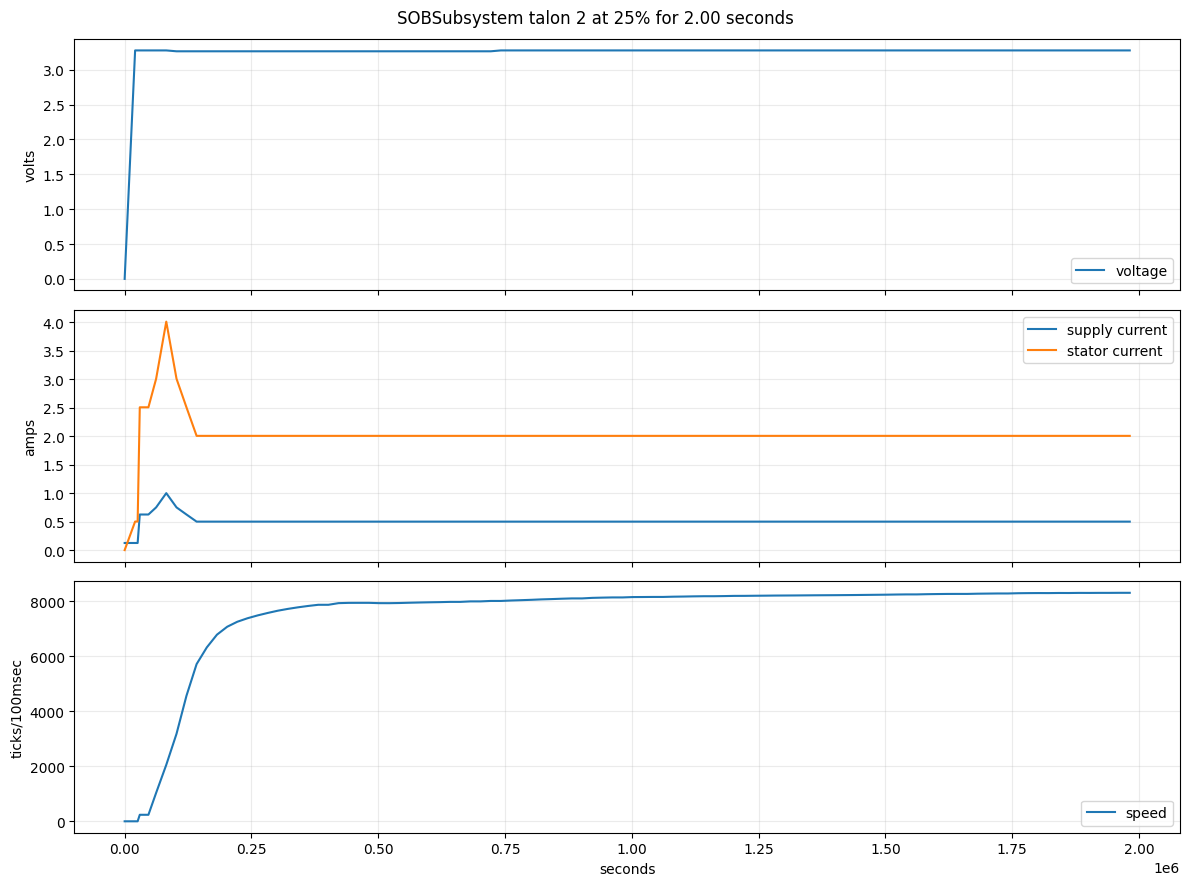

In [18]:
# create the figure that contains all three subplots (called axes by Matplotlib)
fig, (ax_voltage, ax_current, ax_speed) = plt.subplots(nrows=3, sharex="all", layout="tight", figsize=(12, 9))

# timestamp is reused for each plot
timestamp = c0t2['msec_elapsed']

# create voltage plot
voltage = c0t2['voltage']
ax_voltage.plot(timestamp, voltage)
ax_voltage.legend(['voltage'])
ax_voltage.set_ylabel('volts')
ax_voltage.grid(visible=True, alpha=0.25)

# create the current plot
currents = c0t2[['supply_current', 'stator_current']]
ax_current.plot(timestamp, currents)
ax_current.legend(['supply current', 'stator current'])
ax_current.set_ylabel('amps')
ax_current.grid(visible=True, alpha=0.25)

# create the speed plot
speed = c0t2['speed']
ax_speed.plot(timestamp, speed)
ax_speed.legend(['speed'], loc='lower right')
ax_speed.set(xlabel='seconds', ylabel='ticks/100msec')
ax_speed.grid(visible=True, alpha=0.25)

# create the figure title
name = c0t2.iloc[0, 1]
talon = c0t2.iloc[0, 7]
pct = c0t2.iloc[0, 4] * 100
duration = c0t2.iloc[0, 5] / 1e6
_ = fig.suptitle(f"{name} talon {talon} at {pct:0.0f}% for {duration:0.2f} seconds")

## Plotting Health Check Data for Multiple Talons
Reusing the single talon dataframe, `c0t2`, created above and adding data from the same case's talon 1 in `c0t1`.

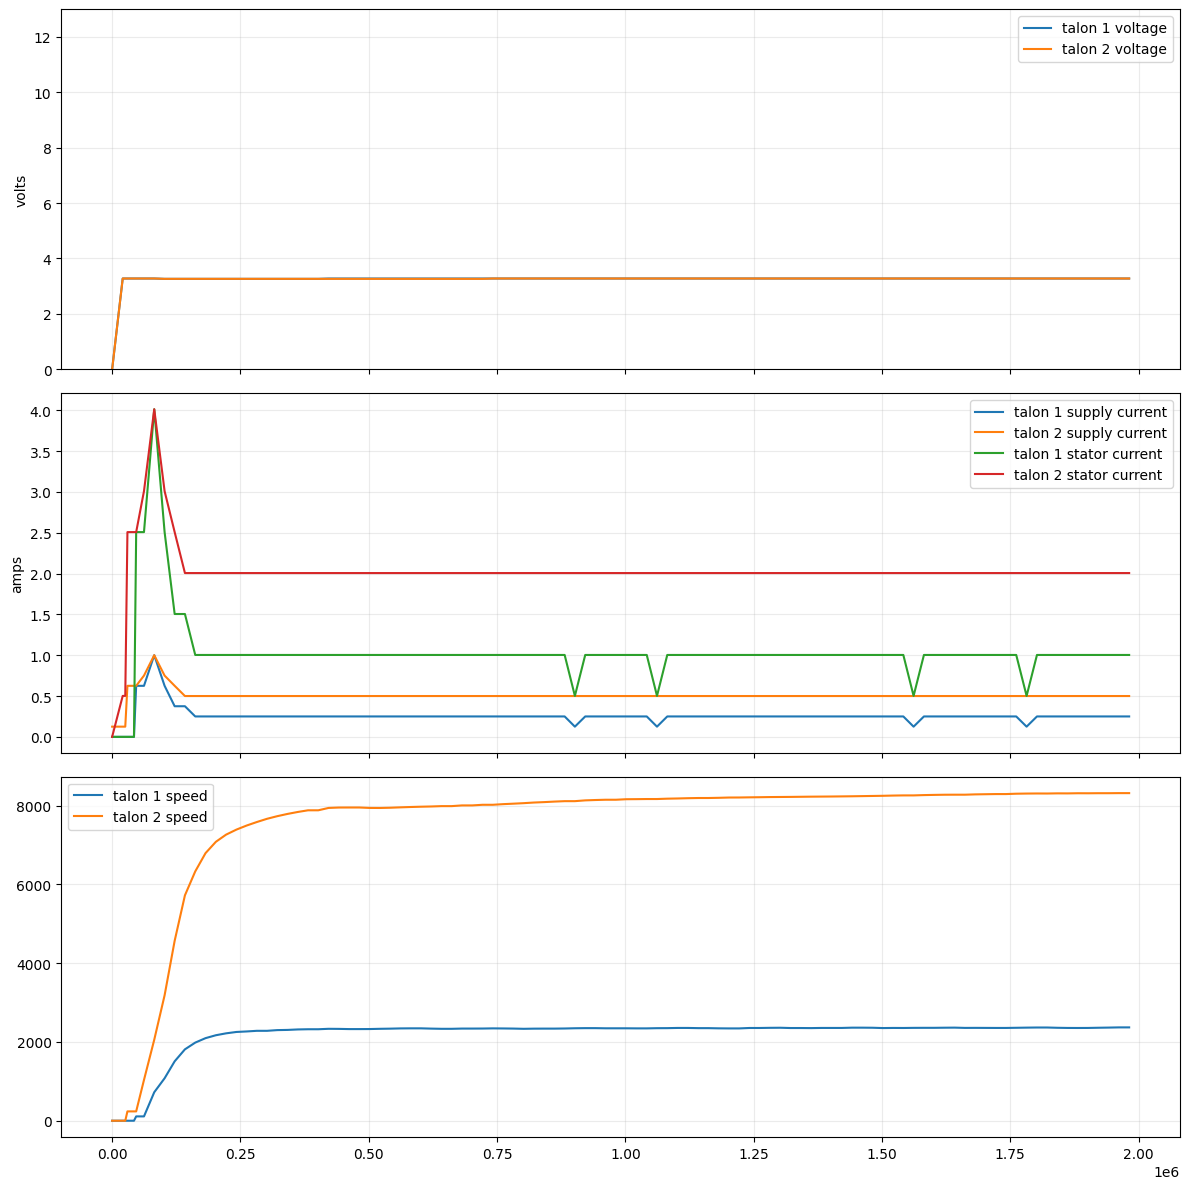

In [26]:
case = health_checks["case"] == 0
talon = health_checks["talon_measured"] == 1
c0t1 = health_checks[case & talon]

# timestamp is reused for each plot
timestamp = c0t2['msec_elapsed']

# create the figure that contains all three subplots (called axes by Matplotlib)
fig, (ax_voltage, ax_current, ax_speed) = plt.subplots(nrows=3, sharex="all", layout="tight",
                                                       figsize=(12, 12))

# create voltage plot
ax_voltage.plot(timestamp, c0t1['voltage'])
ax_voltage.plot(timestamp, c0t2['voltage'])
ax_voltage.legend(['talon 1 voltage', 'talon 2 voltage'])
ax_voltage.set(ylabel='volts', ylim=(0, 13))
ax_voltage.grid(visible=True, alpha=0.25)

# create current plot
ax_current.plot(timestamp, c0t1['supply_current'])
ax_current.plot(timestamp, c0t2['supply_current'])
ax_current.plot(timestamp, c0t1['stator_current'])
ax_current.plot(timestamp, c0t2['stator_current'])
ax_current.legend(
    ['talon 1 supply current', 'talon 2 supply current', 'talon 1 stator current', 'talon 2 stator current'])
ax_current.set_ylabel('amps')
ax_current.grid(visible=True, alpha=0.25)

# create speed plot
speed = c0t2['speed']
ax_speed.plot(timestamp, c0t1['speed'])
ax_speed.plot(timestamp, c0t2['speed'])
ax_speed.legend(['talon 1 speed', 'talon 2 speed'])
ax_speed.grid(visible=True, alpha=0.25)


In [28]:
with open('thrifty.json') as f:
    j = json.load(f)

meta = pd.DataFrame(j["meta"])
meta

,case,name,talon,type,output,duration
0,0,SwerveDriveSubsystem,0,time,0.25,5000000
1,1,SwerveDriveSubsystem,0,time,0.50,5000000
2,2,SwerveDriveSubsystem,0,time,0.75,5000000
3,3,SwerveDriveSubsystem,0,time,-0.25,5000000
4,4,SwerveDriveSubsystem,0,time,-0.50,5000000
5,5,SwerveDriveSubsystem,0,time,-0.75,5000000
6,6,SwerveDriveSubsystem,10,time,0.25,5000000
7,7,SwerveDriveSubsystem,10,time,0.50,5000000
8,8,SwerveDriveSubsystem,10,time,0.75,5000000
9,9,SwerveDriveSubsystem,10,time,-0.25,5000000


In [29]:
data = pd.DataFrame(j["data"])
health_checks = pd.merge(meta, data, on="case", suffixes=('_set', '_measured'))
health_checks

,case,name,talon_set,type,output,duration,msec_elapsed,talon_measured,voltage,position,speed,supply_current,stator_current
0,0,SwerveDriveSubsystem,0,time,0.25,5000000,0,0,0.000000,3.0,0.0,0.00,0.000000
1,0,SwerveDriveSubsystem,0,time,0.25,5000000,20054,0,3.153226,3.0,0.0,0.00,0.000000
2,0,SwerveDriveSubsystem,0,time,0.25,5000000,40522,0,3.153226,3.0,0.0,0.00,0.000000
3,0,SwerveDriveSubsystem,0,time,0.25,5000000,60589,0,3.153226,3.0,0.0,0.25,1.002941
4,0,SwerveDriveSubsystem,0,time,0.25,5000000,79920,0,3.153226,3.0,0.0,0.25,1.002941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12027,11,SwerveDriveSubsystem,10,time,-0.75,5000000,4919968,13,-9.147019,0.0,0.0,0.00,0.000000
12028,11,SwerveDriveSubsystem,10,time,-0.75,5000000,4940108,13,-9.147019,0.0,0.0,0.00,0.000000
12029,11,SwerveDriveSubsystem,10,time,-0.75,5000000,4959871,13,-9.147019,0.0,0.0,0.00,0.000000
12030,11,SwerveDriveSubsystem,10,time,-0.75,5000000,4980198,13,-9.147019,0.0,0.0,0.00,0.000000


In [30]:
case = health_checks["case"] == 2
talon = health_checks["talon_measured"] == 0
c2t0 = health_checks[case & talon]

talon = health_checks["talon_measured"] == 1
c2t1 = health_checks[case & talon]

talon = health_checks["talon_measured"] == 2
c2t2 = health_checks[case & talon]

talon = health_checks["talon_measured"] == 3
c2t3 = health_checks[case & talon]

timestamp = c2t0['msec_elapsed']

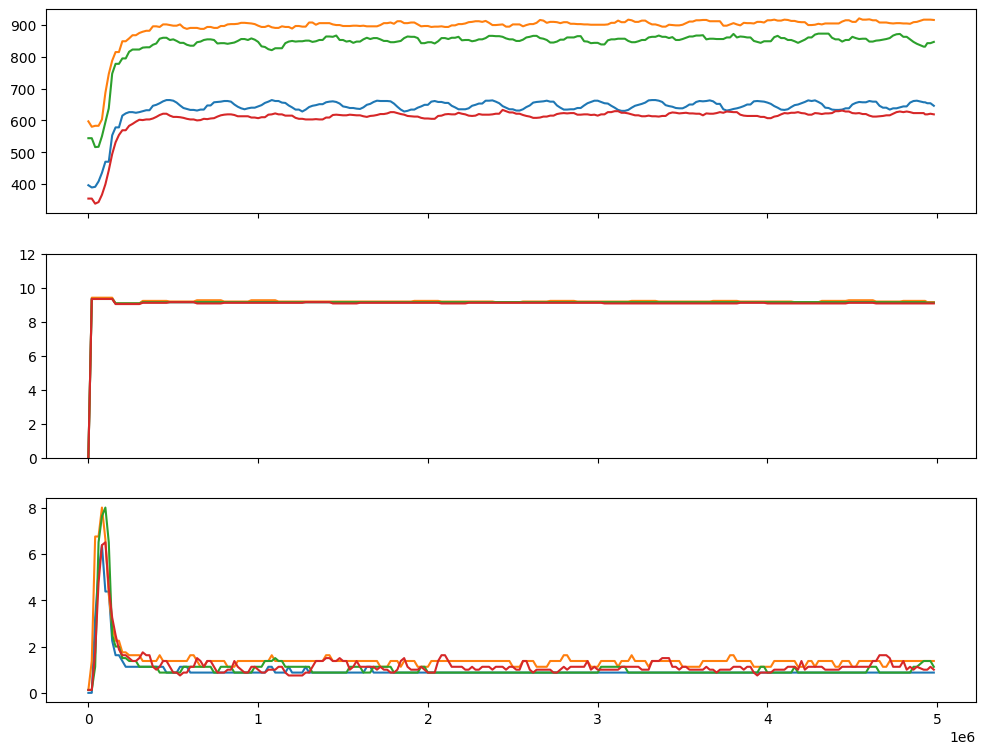

In [31]:
fix, (ax_speed, ax_voltage, ax_current) = plt.subplots(3, 1, sharex="all", figsize=(12, 9))

ax_speed.plot(timestamp, c2t0['speed'])
ax_speed.plot(timestamp, c2t1['speed'])
ax_speed.plot(timestamp, c2t2['speed'])
ax_speed.plot(timestamp, c2t3['speed'])

ax_voltage.plot(timestamp, c2t0['voltage'])
ax_voltage.plot(timestamp, c2t1['voltage'])
ax_voltage.plot(timestamp, c2t2['voltage'])
ax_voltage.plot(timestamp, c2t3['voltage'])
ax_voltage.set_ylim(0, 12)

ax_current.plot(timestamp, c2t0['supply_current'])
ax_current.plot(timestamp, c2t1['supply_current'])
ax_current.plot(timestamp, c2t2['supply_current'])
ax_current.plot(timestamp, c2t3['supply_current'])